# Goals

* Create a pipeline to gather new datasets from GEO and SRA

# Init

In [1]:
import os
import operator
from functools import partial
from pprint import pprint
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any, TypedDict, Sequence
from pydantic import BaseModel, Field
from Bio import Entrez
import pandas as pd
from dotenv import load_dotenv
from langgraph.types import Send
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import START, END, StateGraph

In [2]:
from SRAgent.agents.entrez import create_entrez_agent
from SRAgent.agents.utils import create_step_summary_chain
from SRAgent.agents.convert import create_convert_graph, invoke_convert_graph
from SRAgent.agents.metadata import create_metadata_graph, invoke_metadata_graph, get_metadata_items

In [3]:
# setup
load_dotenv()
pd.set_option('display.max_colwidth', 1000)
os.environ["DEBUG_MODE"] = "TRUE"

In [4]:
# checks
if os.getenv("DEBUG_MODE") == "TRUE":
    print("DEBUG_MODE is enabled.")

DEBUG_MODE is enabled.


In [5]:
# set up Entrez
Entrez.email = "nick.youngblut@arcinstitute.org"
Entrez.api_key = os.getenv("NCBI_API_KEY")

# Graph

In [6]:
class TopState(TypedDict):
    """
    Shared state of the agents in the graph
    """
    # messages
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # database
    database: str
    # dataset entrez ID
    entrez_id: str
    # accessions
    SRX: Annotated[List[str], operator.add]
    SRP: Annotated[List[List[str]], operator.add]
    SRR: Annotated[List[List[str]], operator.add]
    # is_illumina
    is_illumina: Annotated[List[str], operator.add]
    # is_single_cell
    is_single_cell: Annotated[List[str], operator.add]
    # is_paired_end
    is_paired_end: Annotated[List[str], operator.add]
    # is_10x
    is_10x: Annotated[List[str], operator.add]
    # organism
    organism: Annotated[List[str], operator.add]

## Nodes

In [7]:
# create entrez agent
entrez_agent = create_entrez_agent()
step_summary_chain = create_step_summary_chain() 

## test invoke agent
input = {"messages": [("user", "Convert GSE121737 to SRX accessions")]}
#invoke_entrez_agent(input, entrez_agent, step_summary_chain)

In [8]:
# create convert graph
def invoke_convert_graph(
    state: TopState,
    graph: StateGraph,
    to_return: List[str] = ["SRX"]
) -> Annotated[dict, "Response from the graph"]:
    """
    Invoke the graph to convert Entrez IDs & non-SRA accessions to SRA accessions
    """
    entrez_id = state["entrez_id"]
    msg = f"Obtain all SRX accessions for the Entrez ID {entrez_id}"
    state = {"messages" : [HumanMessage(content=msg)], "database": "sra", "entrez_id": entrez_id}    
    response = graph.invoke(state)
    # filter to just the keys we want to return
    return {key: [response[key]] for key in to_return}

invoke_convert_graph_p = partial(
    invoke_convert_graph, 
    graph=create_convert_graph(), 
    to_return=["SRX", "SRP", "SRR"]
)

# invoke convert graph
# print(invoke_convert_graph_p({"entrez_id": "34747624"}))

In [9]:
# metadata subgraph
invoke_metadata_graph_p = partial(
    invoke_metadata_graph,
    graph = create_metadata_graph(),
)

In [10]:
# Parallel invoke of the subgraph
def continue_to_metadata(state: TopState):
    # format the prompt for the metadata graph
    prompt = "\n".join([
        "For the SRA accession {SRX_accession}, find the following information:",
        ] + get_metadata_items()
    )
    
    # submit each accession to the metadata graph
    responses = []
    for SRP,SRX,SRR in zip(state["SRP"], state["SRX"], state["SRR"]):
        for SRX_accession in SRX:
            input = {
                "database": state["database"],
                "entrez_id": state["entrez_id"],
                "SRX": SRX_accession,
                "SRP": SRP,
                "SRR": SRR,
                "messages": [HumanMessage(prompt.format(SRX_accession=SRX_accession))]
            }
            responses.append(Send("metadata_graph_node", input))
    # return messages 
    return responses
    #return [{"database" : state["database"]}]

In [11]:
def final_state(state: TopState):
    # return final state
    return {
        #"messages": state["messages"],
        "database": state["database"],
        "entrez_id": state["entrez_id"],
        "SRP": state["SRP"],
        "SRX": state["SRX"],
        "SRR": state["SRR"],
    }

## Compile

In [12]:
#-- graph --#
workflow = StateGraph(TopState)

# nodes
workflow.add_node("convert_graph_node", invoke_convert_graph_p)
workflow.add_node("metadata_graph_node", invoke_metadata_graph_p)
workflow.add_node("final_state_node", final_state)

# edges
workflow.add_edge(START, "convert_graph_node")
workflow.add_conditional_edges("convert_graph_node", continue_to_metadata, ["metadata_graph_node"])
workflow.add_edge("metadata_graph_node", "final_state_node")
workflow.add_edge("final_state_node", END)

# compile the graph
graph = workflow.compile()

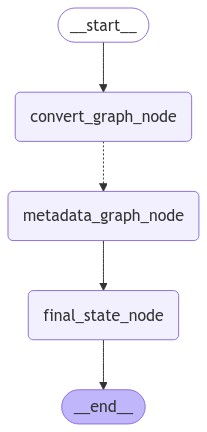

In [13]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [ ]:
# Call the graph: SRA database
final_state = None
input = {"entrez_id": "34747624", "database": "sra"}
    
for step in graph.stream(input, subgraphs=True, config={"max_concurrency" : 3, "recursion_limit": 200}):
    print(step)
    final_state = step
print("---")
print(final_state)

In [15]:
# Call the graph: SRA database
final_state = None
entrez_ids = ["36178521", "35087712", "27978912"]
for entrez_id in entrez_ids:
    print(f"# Running graph for Entrez ID {entrez_id}")
    input = {"entrez_id": entrez_id, "database": "sra"}
    for step in graph.stream(input, subgraphs=True, config={"max_concurrency" : 3, "recursion_limit": 200}):
        print(step)

# Running graph for Entrez ID 36178521
(('convert_graph_node:43075d3c-15b2-5dc2-3f88-6ddcd87ef7f9', 'entrez_agent_node:a2ab47fd-c24f-d3fe-97db-c6583371316f'), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8qhm2udSLTZMm4cturLku5lN', 'function': {'arguments': '{"message":"Use eFetch to obtain the SRX accessions for Entrez ID 36178521."}', 'name': 'invoke_efetch_worker'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 1042, 'total_tokens': 1077, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f857225f-3546-4802-8f0b-3e90f9ecd5b4-0', tool_calls=[{'name': 'invoke_efetch_worker', 'args': {'me

In [16]:
# Call the graph: SRA database
final_state = None
entrez_ids = ["27978915", "36178506", "35087715"]
for entrez_id in entrez_ids:
    print(f"# Running graph for Entrez ID {entrez_id}")
    input = {"entrez_id": entrez_id, "database": "sra"}
    for step in graph.stream(input, subgraphs=True, config={"max_concurrency" : 3, "recursion_limit": 200}):
        print(step)

# Running graph for Entrez ID 27978915
(('convert_graph_node:37c27252-a957-c990-4068-965fb34d9aa7', 'entrez_agent_node:756c1b82-ff0c-527d-9e7e-d45045b4c1a4'), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kNo7BO9pK61fvGN1pzNiYSgb', 'function': {'arguments': '{"message":"Fetch the SRX accessions for Entrez ID 27978915."}', 'name': 'invoke_efetch_worker'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 1042, 'total_tokens': 1073, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-28e7bacd-bbd9-43c1-888a-c8a368059b79-0', tool_calls=[{'name': 'invoke_efetch_worker', 'args': {'message': 'Fetch 